In [ ]:
#get the project

Cloning into 'assignment3-21-robustnet-1'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 63 (delta 24), reused 29 (delta 7), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [ ]:
%cd /content/assignment3-21-robustnet-1/

/content/assignment3-21-robustnet-1


In [ ]:
!pip install -r requirements.txt

In [ ]:
#!/usr/bin/env python3 
import os
import argparse
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from random import randint

from attacks import *
from utils import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

valid_size = 1024
batch_size = 32
criterion = nn.NLLLoss()
'''Basic neural network architecture (from pytorch doc).'''


class Net(nn.Module):
    model_file = "models/default_model.pth"
    '''This file will be loaded to test your model. Use --model-file to load/store a different model.'''

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

    def save(self, model_file):
        '''Helper function, use it to save the model weights after training.'''
        torch.save(self.state_dict(), model_file)

    def load(self, model_file):
        self.load_state_dict(torch.load(model_file, map_location=torch.device(device)))

    def load_for_testing(self, project_dir='./'):
        '''This function will be called automatically before testing your
           project, and will load the model weights from the file
           specify in Net.model_file.
           
           You must not change the prototype of this function. You may
           add extra code in its body if you feel it is necessary, but
           beware that paths of files used in this function should be
           refered relative to the root of your project directory.
        '''
        self.load(os.path.join(project_dir, Net.model_file))


def train_model(net, train_loader, pth_filename, num_epochs):
    '''Basic training function'''
    print("Starting training")

    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    train_loss = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        loss_per_epoch = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_per_epoch += loss.item()
            loss.backward()
            optimizer.step()

            #Add adversarial data
            #Here we just kept epsilon = 0.08
            data_grad = inputs.grad.data
            adv_data=fgsm(images, 0.08, data_grad)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(adv_data)
            loss = criterion(outputs, labels)
            loss_per_epoch += loss.item()
            loss.backward()
            optimizer.step()

        epoch_loss = loss_per_epoch / (len(train_loader)*2)
        train_loss.append(epoch_loss)
        print(f'epoch : {epoch} --- loss : {epoch_loss} ')

    net.save(pth_filename)
    print('Model saved in {}'.format(pth_filename))
    return train_loss


####### Testing ############
def test_natural(net, test_loader):
    '''Basic testing function.'''

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


######################## Attack Testing ########################
def test_fgsm(net, test_loader, epsilon):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        images.requires_grad = True
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, nat_pred = torch.max(outputs.data, 1)
        if nat_pred.item() != labels.item():
            continue
        # if test sample is correctly predicted
        loss = criterion(outputs, labels)
        net.zero_grad()
        loss.backward()

        data_grad = images.grad.data
        adv_data = fgsm(images, epsilon, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return 100 * final_acc


def test_pgdlinf(net, test_loader, eta, eps, steps):
    correct = 0
    for i, data in enumerate(test_loader, 0):
        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):
            # calculate outputs by running images through the network
            adv_data.requires_grad = True
            outputs = net(adv_data)

            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():
                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgdlinf(adv_data, images, eta, eps, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc


def test_pgdl2(net, test_loader, eta, eps, steps, eps_for_div):
    correct = 0
    for i, data in enumerate(test_loader, 0):

        images, labels = data[0].to(device), data[1].to(device)
        adv_data = images.clone().detach().to(device)
        for _ in range(steps):

            adv_data.requires_grad = True
            outputs = net(adv_data)

            _, nat_pred = torch.max(outputs.data, 1)
            if nat_pred.item() != labels.item():

                break
            loss = criterion(outputs, labels)
            net.zero_grad()
            loss.backward()

            data_grad = adv_data.grad.data
            adv_data = pgdl2(adv_data, images, eta, eps, eps_for_div, data_grad)
        output = net(adv_data)
        _, adv_pred = torch.max(output.data, 1)
        if adv_pred.item() == labels.item():
            correct += 1
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(test_loader), final_acc))
    return 100 * final_acc



##########################################

def get_train_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the training part.'''

    indices = list(range(len(dataset)))
    train_sampler = torch.utils.data.SubsetRandomSampler(indices[valid_size:])
    train = torch.utils.data.DataLoader(dataset, sampler=train_sampler, batch_size=batch_size)

    return train


def get_validation_loader(dataset, valid_size=1024, batch_size=32):
    '''Split dataset into [train:valid] and return a DataLoader for the validation part.'''

    indices = list(range(len(dataset)))
    valid_sampler = torch.utils.data.SubsetRandomSampler(indices[:valid_size])
    valid = torch.utils.data.DataLoader(dataset, sampler=valid_sampler, batch_size=batch_size)

    return valid



In [ ]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_3_7_05.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_3_7_05.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_all.pth", 20)
print("Model save to '{}'.".format("models/adversarial_all.pth"))

Files already downloaded and verified
Starting training
epoch : 0 --- loss : 1.521342628997005 
epoch : 1 --- loss : 1.520066463490496 
epoch : 2 --- loss : 1.5162479990568916 
epoch : 3 --- loss : 1.5172028524240273 
epoch : 4 --- loss : 1.5156421710495955 
epoch : 5 --- loss : 1.517751336876354 
epoch : 6 --- loss : 1.5113327375832348 
epoch : 7 --- loss : 1.5172140620098948 
epoch : 8 --- loss : 1.5168746795084336 
epoch : 9 --- loss : 1.5124454005089507 
epoch : 10 --- loss : 1.5103917240499543 
epoch : 11 --- loss : 1.5106451984080462 
epoch : 12 --- loss : 1.508977986928972 
epoch : 13 --- loss : 1.509149081873629 
epoch : 14 --- loss : 1.5074719823369682 
epoch : 15 --- loss : 1.5110504051231233 
epoch : 16 --- loss : 1.5109638102545657 
epoch : 17 --- loss : 1.5085850079971126 
epoch : 18 --- loss : 1.5053224459975056 
epoch : 19 --- loss : 1.5090626085308054 
Model saved in models/adversarial_all.pth
Model save to 'models/adversarial_all.pth'.


In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_82.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_82.pth"))

Files already downloaded and verified
Starting training
epoch : 0 --- loss : 2.054803913282772 
epoch : 1 --- loss : 2.051104817318029 
epoch : 2 --- loss : 2.046331473721701 
epoch : 3 --- loss : 2.0437407043149936 
epoch : 4 --- loss : 2.0448552927478008 
epoch : 5 --- loss : 2.0363854977291913 
epoch : 6 --- loss : 2.0361093507238963 
epoch : 7 --- loss : 2.0310107886421376 
epoch : 8 --- loss : 2.0293752455793124 
epoch : 9 --- loss : 2.029071796502964 
epoch : 10 --- loss : 2.0212729889376346 
epoch : 11 --- loss : 2.0220393972175716 
epoch : 12 --- loss : 2.0193008613267183 
epoch : 13 --- loss : 2.014540722047403 
epoch : 14 --- loss : 2.0141091105168663 
epoch : 15 --- loss : 2.0159653760906453 
epoch : 16 --- loss : 2.007206573547062 
epoch : 17 --- loss : 2.0111265840443187 
epoch : 18 --- loss : 2.0066997026848217 
epoch : 19 --- loss : 2.0027330792432982 
Model saved in models/adversarial_model_82.pth
Model save to 'models/adversarial_model_82.pth'.


In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_10.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_10.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_1.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_1.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_19.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_15.pth"))

Files already downloaded and verified
Starting training
epoch : 0 --- loss : 0.9842240375087667 
epoch : 1 --- loss : 0.9777143424404827 
epoch : 2 --- loss : 0.969240802743519 
epoch : 3 --- loss : 0.9709523917120473 
epoch : 4 --- loss : 0.9647462345820327 
epoch : 5 --- loss : 0.9640322574149698 
epoch : 6 --- loss : 0.9581814369516463 
epoch : 7 --- loss : 0.9584771523545335 
epoch : 8 --- loss : 0.9577088207249779 
epoch : 9 --- loss : 0.9557467685960073 
epoch : 10 --- loss : 0.95512484307483 
epoch : 11 --- loss : 0.950960716202242 
epoch : 12 --- loss : 0.9479156221968142 
epoch : 13 --- loss : 0.9496853934013322 
epoch : 14 --- loss : 0.9477578679636208 
epoch : 15 --- loss : 0.947908280532902 
epoch : 16 --- loss : 0.944550440309096 
epoch : 17 --- loss : 0.94455579827904 
epoch : 18 --- loss : 0.9398520119454173 
epoch : 19 --- loss : 0.9391299422506723 
Model saved in models/adversarial_model_19.pth
Model save to 'models/adversarial_model_15.pth'.


In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_5.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_5.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_3.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_3.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_2.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_2.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_50.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_50.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_30.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_30.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_8.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_8.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_4.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_4.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_4.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_4.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_6.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_6.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_7.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_7.pth"))

Files already downloaded and verified
Starting training
epoch : 0 --- loss : 0.8716112991696398 
epoch : 1 --- loss : 0.8097426913153066 
epoch : 2 --- loss : 0.7863650375151073 
epoch : 3 --- loss : 0.7630997709224303 
epoch : 4 --- loss : 0.7536799942029507 
epoch : 5 --- loss : 0.7348195646033615 
epoch : 6 --- loss : 0.7317032479309398 
epoch : 7 --- loss : 0.7191171658126203 
epoch : 8 --- loss : 0.7064728950418576 
epoch : 9 --- loss : 0.7050059931474396 
epoch : 10 --- loss : 0.704137877021581 
epoch : 11 --- loss : 0.7016815130412092 
epoch : 12 --- loss : 0.6944655748224099 
epoch : 13 --- loss : 0.6858372835163817 
epoch : 14 --- loss : 0.6769473344467186 
epoch : 15 --- loss : 0.6767325636770778 
epoch : 16 --- loss : 0.6755065910085053 
epoch : 17 --- loss : 0.6739300242013825 
epoch : 18 --- loss : 0.6691955089073928 
epoch : 19 --- loss : 0.6623135166155122 
Model saved in models/adversarial_model_7.pth
Model save to 'models/adversarial_model_7.pth'.


In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_9.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_9.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_7-5.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_7-5.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_9-5.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_9-5.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_9-9.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_9-9.pth"))

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()])
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=train_transform)
train_loader = get_train_loader(cifar, valid_size, batch_size)
train_model(net, train_loader, "models/adversarial_model_03_3_30.pth", 20)
print("Model save to '{}'.".format("models/adversarial_model_03_3_30.pth"))

In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_3_7_05.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 57.91015625


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_10.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 63.671875


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_5.pth")
acc = test_natural(net, valid_loader)

Files already downloaded and verified


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_8.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 63.8671875


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_7.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 54.296875


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_9.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_7-5.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 61.62109375


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_50.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 63.28125


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_6.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 61.03515625


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_6.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 59.1796875


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_30.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 64.0625


In [ ]:
cifar = torchvision.datasets.CIFAR10('./data/', download=True, transform=transforms.ToTensor())
valid_loader = get_validation_loader(cifar, valid_size, 1)  # batch size one for attack test otherwise put 32
net.load("models/adversarial_model_03_3_30.pth")
acc = test_natural(net, valid_loader)
print("Model natural accuracy (valid): {}".format(acc))

Files already downloaded and verified
Model natural accuracy (valid): 60.15625


In [ ]:
#Accuracies of Trained model (with adversarial fgsm (0.03) data) with FGSM Attack 
epsilons = [0, .005, .01, .015, .02, .025, .03,.035,.04,.045,.050,.055,.06,.065,.07,.075,.08,.085,.09,.095,0.1]

accuracies_3_7_05_fgsm = []
net.load("models/adversarial_model_3_7_05.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_3_7_05_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 593 / 1024 = 0.5791015625
Model fgsm attack accuracy (validation): 57.91015625
Epsilon: 0.005	Test Accuracy = 509 / 1024 = 0.4970703125
Model fgsm attack accuracy (validation): 49.70703125
Epsilon: 0.01	Test Accuracy = 443 / 1024 = 0.4326171875
Model fgsm attack accuracy (validation): 43.26171875
Epsilon: 0.015	Test Accuracy = 395 / 1024 = 0.3857421875
Model fgsm attack accuracy (validation): 38.57421875
Epsilon: 0.02	Test Accuracy = 338 / 1024 = 0.330078125
Model fgsm attack accuracy (validation): 33.0078125
Epsilon: 0.025	Test Accuracy = 294 / 1024 = 0.287109375
Model fgsm attack accuracy (validation): 28.7109375
Epsilon: 0.03	Test Accuracy = 255 / 1024 = 0.2490234375
Model fgsm attack accuracy (validation): 24.90234375
Epsilon: 0.035	Test Accuracy = 224 / 1024 = 0.21875
Model fgsm attack accuracy (validation): 21.875
Epsilon: 0.04	Test Accuracy = 197 / 1024 = 0.1923828125
Model fgsm attack accuracy (validation): 19.23828125
Epsilon: 0.045	Test Accuracy = 1

In [ ]:
accuracies_10_fgsm = []
net.load("models/adversarial_model_10.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_10_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_all_fgsm = []
net.load("models/adversarial_all.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_all_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

Epsilon: 0	Test Accuracy = 590 / 1024 = 0.576171875
Model fgsm attack accuracy (validation): 57.6171875
Epsilon: 0.005	Test Accuracy = 518 / 1024 = 0.505859375
Model fgsm attack accuracy (validation): 50.5859375
Epsilon: 0.01	Test Accuracy = 455 / 1024 = 0.4443359375
Model fgsm attack accuracy (validation): 44.43359375
Epsilon: 0.015	Test Accuracy = 400 / 1024 = 0.390625
Model fgsm attack accuracy (validation): 39.0625
Epsilon: 0.02	Test Accuracy = 356 / 1024 = 0.34765625
Model fgsm attack accuracy (validation): 34.765625
Epsilon: 0.025	Test Accuracy = 323 / 1024 = 0.3154296875
Model fgsm attack accuracy (validation): 31.54296875
Epsilon: 0.03	Test Accuracy = 295 / 1024 = 0.2880859375
Model fgsm attack accuracy (validation): 28.80859375
Epsilon: 0.035	Test Accuracy = 279 / 1024 = 0.2724609375
Model fgsm attack accuracy (validation): 27.24609375
Epsilon: 0.04	Test Accuracy = 261 / 1024 = 0.2548828125
Model fgsm attack accuracy (validation): 25.48828125
Epsilon: 0.045	Test Accuracy = 236

In [ ]:
accuracies_1_fgsm = []
net.load("models/adversarial_model_1.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_1_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_19_fgsm = []
net.load("models/adversarial_model_19.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_19_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_3_fgsm = []
net.load("models/adversarial_model_3.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_3_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_2_fgsm = []
net.load("models/adversarial_model_2.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_2_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_4_fgsm = []
net.load("models/adversarial_model_4.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_4_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_6_fgsm = []
net.load("models/adversarial_model_6.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_6_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_6_fgsm = []
net.load("models/adversarial_model_6.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_6_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_9_fgsm = []
net.load("models/adversarial_model_9.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_9_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_50_fgsm = []
net.load("models/adversarial_model_50.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_50_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_8_fgsm = []
net.load("models/adversarial_model_8.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_8_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_7_fgsm = []
net.load("models/adversarial_model_7.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_7_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_30_fgsm = []
net.load("models/adversarial_model_30.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_30_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_82_fgsm = []
net.load("models/adversarial_model_82.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_82_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_03_3_30_fgsm = []
net.load("models/adversarial_model_03_3_30.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_03_3_30_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_5_fgsm = []
net.load("models/adversarial_model_5.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_5_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_50_fgsm = []
net.load("models/adversarial_model_50.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_50_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_05_fgsm = []
net.load("models/adversarial_model_05.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_05_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_7_5_fgsm = []
net.load("models/adversarial_model_7-5.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_7_5_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_9_5_fgsm = []
net.load("models/adversarial_model_9-5.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_9_5_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_9_9_fgsm = []
net.load("models/adversarial_model_9-9.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_9_9_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

In [ ]:
accuracies_fgsm = []
net.load("models/basic_model.pth")
for eps in epsilons:
  acc = test_fgsm(net, valid_loader, eps)
  accuracies_fgsm.append(acc)
  print("Model fgsm attack accuracy (validation): {}".format(acc))

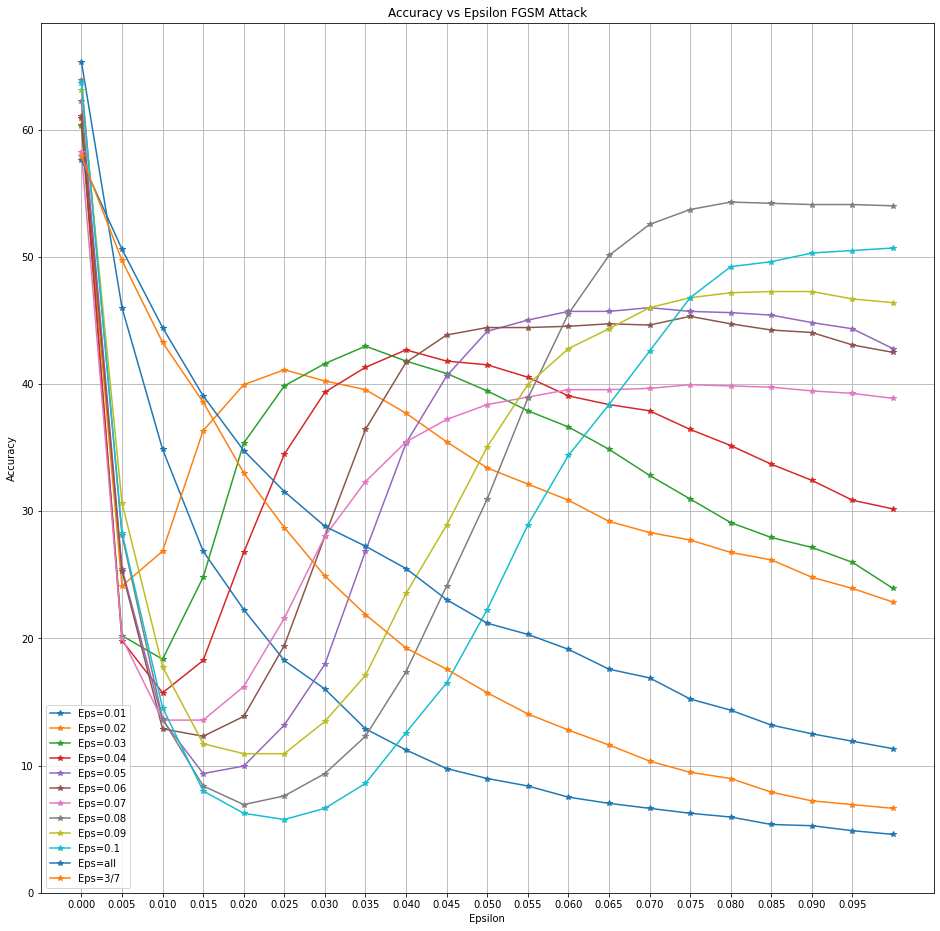

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
plt.plot(epsilons, accuracies_1_fgsm, "*-",label="Eps=0.01")
plt.plot(epsilons, accuracies_2_fgsm, "*-",label="Eps=0.02")
plt.plot(epsilons, accuracies_3_fgsm, "*-",label="Eps=0.03")
plt.plot(epsilons, accuracies_4_fgsm, "*-",label="Eps=0.04")
plt.plot(epsilons, accuracies_5_fgsm, "*-",label="Eps=0.05")
plt.plot(epsilons, accuracies_6_fgsm, "*-",label="Eps=0.06")
plt.plot(epsilons, accuracies_7_fgsm, "*-",label="Eps=0.07")
plt.plot(epsilons, accuracies_8_fgsm, "*-",label="Eps=0.08")
plt.plot(epsilons, accuracies_9_fgsm, "*-",label="Eps=0.09")
plt.plot(epsilons, accuracies_10_fgsm, "*-",label="Eps=0.1")
plt.plot(epsilons, accuracies_all_fgsm, "*-",label="Eps=all")
#Combining 0.03 and 0.07
plt.plot(epsilons, accuracies_3_7_05_fgsm, "*-",label="Eps=3/7")
plt.yticks(np.arange(0, 65, step=10))
plt.xticks(np.arange(0, .1, step=0.005))
plt.title("Accuracy vs Epsilon FGSM Attack")
plt.grid(True)
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend()
plt.show()